# Visualizing Performance Summary for Cell Health Target Variables

**Gregory Way, 2019**

For both binary and regression models.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

## Load Data

In [2]:
results_dir <- "results"
consensus <- "median"

figure_dir <- file.path("figures", "summary")
dir.create(figure_dir)

Warning message in dir.create(figure_dir):
“'figures/summary' already exists”

In [3]:
# Regression Results
regression_file <- file.path(results_dir, 
                             paste0("full_cell_health_regression_", consensus, ".tsv.gz"))
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

# Classification Results
roc_file <- file.path(results_dir,
                      paste0("full_cell_health_roc_results_", consensus, ".tsv.gz"))
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

pr_file <- file.path(results_dir,
                     paste0("full_cell_health_pr_results_", consensus, ".tsv.gz"))
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

# Model Coefficients
coef_file <- file.path(results_dir,
                       paste0("full_cell_health_coefficients_", consensus, ".tsv.gz"))
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols())

# Model Predictions
y_file <- file.path(results_dir,
                    paste0("full_cell_health_y_labels_", consensus, ".tsv.gz"))
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

# Annotated Cell Health Features
feat_file <- file.path("..", "1.generate-profiles", "data", "labels", "feature_mapping_annotated.csv")
label_df <- readr::read_csv(feat_file, col_types = readr::cols())

## Process Data

In [4]:
regression_subset_df <- regression_metrics_df %>%
    dplyr::filter(y_transform == "raw",
                  data_fit == "test",
                  shuffle == "shuffle_false") %>%
    tidyr::spread(key = "metric", value = "value") %>%
    dplyr::select(-y_transform)

print(dim(regression_subset_df))
head(regression_subset_df, 3)

[1] 70  6


target,data_fit,shuffle,cell_line,mse,r_two
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,all,0.4743901,0.3252763
cc_all_large_notround_polynuclear_mean,test,shuffle_false,all,0.2225500,0.1143320
cc_all_large_round_polyploid_mean,test,shuffle_false,all,0.5445049,-1.2715678


In [5]:
auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false")

auc_df$metric <- dplyr::recode_factor(
    auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

auc_df <- auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform)

test_auc_df <- auc_df %>%
    dplyr::filter(data_fit == "test")

train_auc_df <- auc_df %>%
    dplyr::filter(data_fit == "train") %>%
    dplyr::select(-data_fit)

auc_df <- train_auc_df %>%
    dplyr::full_join(test_auc_df,
                     by = c("target", "shuffle", "min_class_count"),
                     suffix = c("_train", "_test"))

print(dim(auc_df))
head(auc_df, 2)

[1] 63  8


target,shuffle,min_class_count,AUROC_train,AUPR_train,data_fit,AUROC_test,AUPR_test
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,shuffle_false,29,0.9492827,0.6349239,test,0.5763889,0.309443
cc_all_large_notround_polynuclear_mean,shuffle_false,21,0.9805809,0.7912741,test,0.9811321,0.500000


In [6]:
metric_df <- regression_subset_df %>%
    dplyr::inner_join(auc_df, by = c("target", "data_fit", "shuffle")) %>%
    dplyr::left_join(label_df, by = c("target" = "updated_name"))

metric_df$mse = abs(metric_df$mse)

metric_df$maria_thumbs_up <- tidyr::replace_na(metric_df$maria_thumbs_up, 0)
metric_df$measurement <- tidyr::replace_na(metric_df$measurement, "other")

metric_df$measurement <- factor(metric_df$measurement,
                                levels = c("apoptosis",
                                           "death",
                                           "cell_viability",
                                           "toxicity",
                                           "dna_damage",
                                           "cell_cycle_arrest",
                                           "g1_arrest",
                                           "g2_arrest",
                                           "g2_m_arrest",
                                           "mitosis",
                                           "s_arrest",
                                           "other"))

metric_df$assay <- factor(metric_df$assay,
                          levels = c("hoechst",
                                     "edu",
                                     "gh2ax",
                                     "ph3",
                                     "hoechst_gh2ax",
                                     "hoechst_edu",
                                     "edu_gh2ax",
                                     "caspase",
                                     "draq",
                                     "draq_caspase",
                                     "many_cell_cycle",
                                     "crispr_efficiency"))
print(dim(metric_df))
head(metric_df, 3)

[1] 63 17


target,data_fit,shuffle,cell_line,mse,r_two,min_class_count,AUROC_train,AUPR_train,AUROC_test,AUPR_test,original_name,feature_type,measurement,maria_thumbs_up,assay,description
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,all,0.4743901,0.3252763,29,0.9492827,0.6349239,0.5763889,0.309443,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots
cc_all_large_notround_polynuclear_mean,test,shuffle_false,all,0.2225500,0.1143320,21,0.9805809,0.7912741,0.9811321,0.500000,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,hoechst,Fraction of cells with large non-round nuclei
cc_all_large_round_polyploid_mean,test,shuffle_false,all,0.5445049,-1.2715678,13,0.9405836,0.4183557,NA,NA,ALL - Large round (polyploid) - Mean per Well,cell_cycle,other,0,hoechst,NA


## Plot Performance

In [7]:
# Set some plotting defaults
measurement_colors <- c(
    "apoptosis" = "#a6cee3",
    "cell_cycle_arrest" = "#1f78b4",
    "cell_viability" = "#b2df8a",
    "death" = "#33a02c",
    "dna_damage" = "#fb9a99", 
    "g1_arrest" = "#fdbf6f",
    "g2_arrest" = "#ff7f00",
    "g2_m_arrest" = "#005c8c",
    "mitosis" = "green",
    "other" = "black",
    "s_arrest" = "#cab2d6",
    "toxicity" = "#6a3d9a"
)

measurement_labels <- c(
    "apoptosis" = "Apoptosis",
    "cell_cycle_arrest" = "Cell Cycle Arrest",
    "cell_viability" = "Cell Viability",
    "death" = "Death",
    "dna_damage" = "DNA Damage", 
    "g1_arrest" = "G1 Arrest",
    "g2_arrest" = "G2 Arrest",
    "g2_m_arrest" = "G2/M Arrest",
    "mitosis" = "Mitosis",
    "other" = "Other",
    "s_arrest" = "S Arrest",
    "toxicity" = "Toxicity"
)

dye_colors <- c(
    "hoechst" = "#639B94",
    "edu" = "#E45242",
    "gh2ax" = "#E2C552",
    "ph3" = "#7B9C32",
    "hoechst_gh2ax" = "#535f52",
    "hoechst_edu" = "#73414b",
    "edu_gh2ax" = "#e37a48",
    "caspase" = "#F7B1C1",
    "draq" = "#FF6699",
    "draq_caspase" = "#7f4a72",
    "many_cell_cycle" = "#E9DFC3",
    "crispr_efficiency" = "black"
)

dye_labels <- c(
    "hoechst" = "Hoechst",
    "edu" = "EdU",
    "gh2ax" = "gH2AX",
    "ph3" = "pH3",
    "hoechst_gh2ax" = "Hoechst + gH2AX",
    "hoechst_edu" = "Hoechst + EdU",
    "edu_gh2ax" = "EdU + gH2AX",
    "caspase" = "Caspase 3/7",
    "draq" = "DRAQ7",
    "draq_caspase" = "DRAQ7 + Caspase 3/7",
    "many_cell_cycle" = "Cell Cycle (Many Dyes)",
    "crispr_efficiency" = "CRISPR Efficiency"
)

Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 7 rows containing missing values (geom_point).”

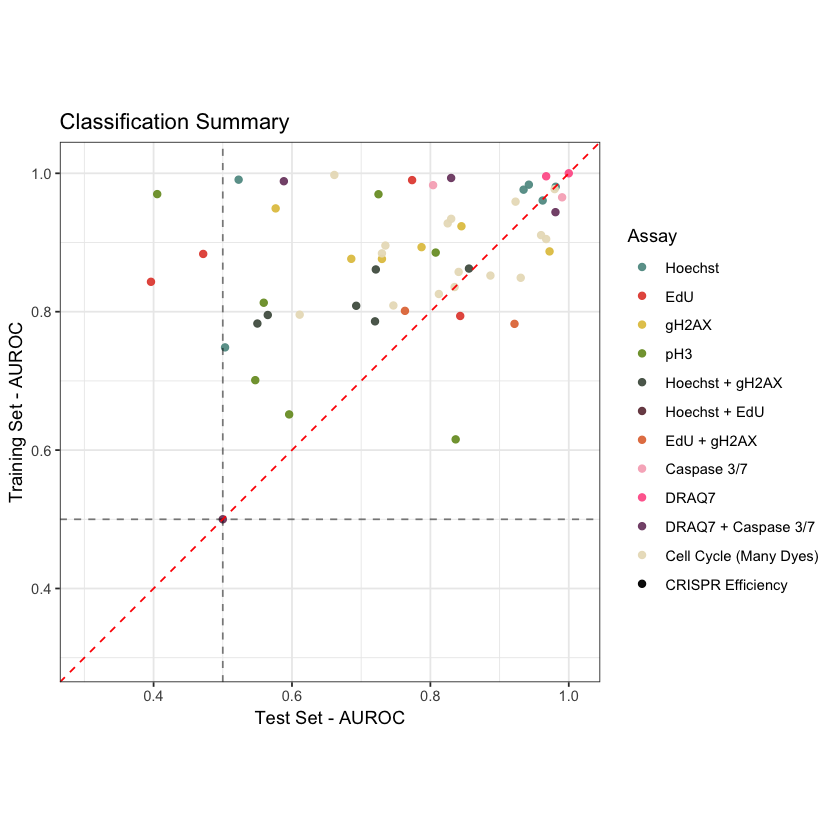

In [9]:
# Note that the points that failed to plot did not contain enough positive samples in test set
ggplot(metric_df,
       aes(x = AUROC_test,
           y = AUROC_train)) +
    geom_point(alpha = 0.95,
               size = 1.7,
               aes(color = assay)) +
    ggtitle("Classification Summary") +
    xlab("Test Set - AUROC") +
    ylab("Training Set - AUROC") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_abline(slope = 1,
                intercept = 0, 
                color = "red",
                linetype = "dashed") +
    xlim(c(0.3, 1.01)) +
    ylim(c(0.3, 1.01)) +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path("figures",
                  paste0("performance_summary_assay_", consensus, ".png"))
ggsave(file, dpi = 300, width = 6, height = 4.5)

Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_point).”

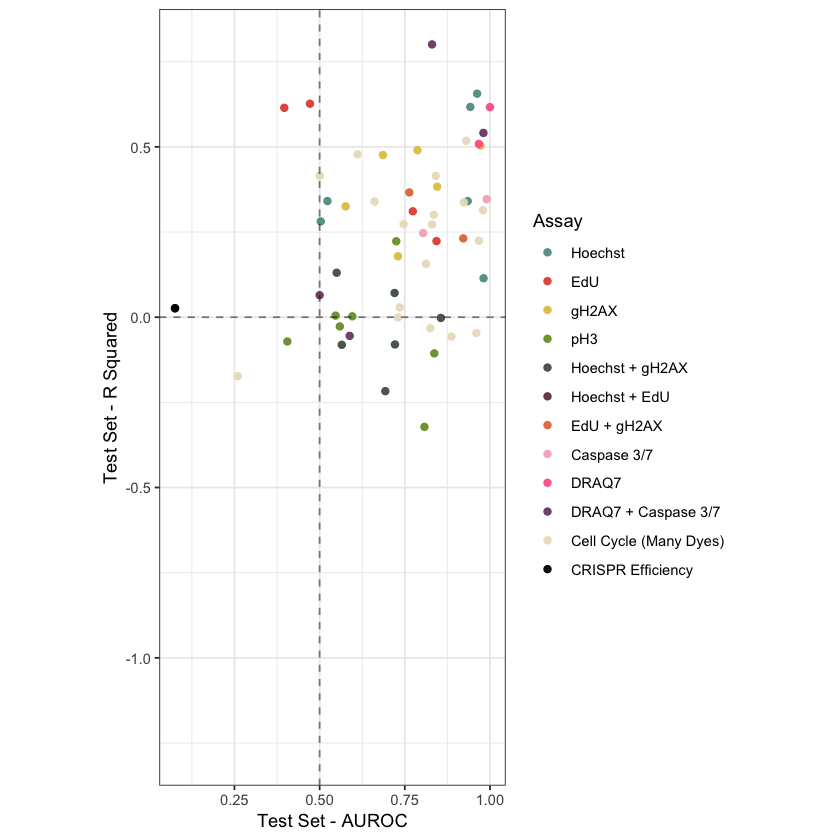

In [10]:
ggplot(metric_df, aes(x = AUROC_test,
                      y = r_two)) +
    geom_point(alpha = 0.95,
               size = 1.7,
               aes(color = assay)) +
    xlab("Test Set - AUROC") +
    ylab("Test Set - R Squared") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path(
    figure_dir,
    paste0("performance_summary_assay_classification_vs_regression_",
           consensus,
           ".png")
)
ggsave(file, dpi = 300, width = 6, height = 4.5)

## Variable Model Performance Comparing Regression vs. Classification

We observe variable performance across model types.
Regression and classification perform differently in different settings.

Regression is likely to be our primary approach, but in some cases it may be worth presenting a classification model.

Make sure to take into account shuffled model performance

In [11]:
# Get data ready for plotting
auc_test_full_df <- dplyr::bind_rows(auroc_df, aupr_df) %>%
    dplyr::left_join(label_df, by = c("target" = "updated_name")) %>%
    dplyr::filter(data_fit == "test")

auc_test_full_real_df <- auc_test_full_df %>%
    dplyr::filter(shuffle == "shuffle_false") %>%
    dplyr::arrange(target, metric)
auc_test_full_shuffle_df <- auc_test_full_df %>%
    dplyr::filter(shuffle == "shuffle_true") %>%
    dplyr::arrange(target, metric)

real_minus_shuffle_df <- auc_test_full_real_df %>%
    dplyr::mutate(
        auc = auc_test_full_real_df$auc - auc_test_full_shuffle_df$auc,
        shuffle = "real_minus_shuffle"
    )

target_order <- real_minus_shuffle_df %>%
    dplyr::filter(metric == "roc") %>%
    dplyr::arrange(desc(auc)) %>%
    dplyr::pull(target)

auc_test_full_df <- auc_test_full_df %>%
    dplyr::bind_rows(real_minus_shuffle_df)

auc_test_full_df$metric <- auc_test_full_df$metric %>%
    dplyr::recode("aupr" = "AUPR", "roc" = "AUROC")

auc_test_full_df$target <- factor(auc_test_full_df$target, levels = rev(target_order))
auc_test_full_df$metric <- factor(auc_test_full_df$metric, levels = c("AUROC", "AUPR"))

print(dim(auc_test_full_df))
head(auc_test_full_df, 2)

[1] 378  13


metric,target,auc,data_fit,shuffle,y_transform,min_class_count,original_name,feature_type,measurement,maria_thumbs_up,assay,description
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
AUROC,cc_all_high_n_spots_h2ax_mean,0.3506944,test,shuffle_true,binarize,29,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots
AUROC,cc_all_high_n_spots_h2ax_mean,0.5763889,test,shuffle_false,binarize,29,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots


In [12]:
# Get side by side plot
metric_df$target <- factor(metric_df$target, levels = rev(target_order))
metric_df <- metric_df %>%
    dplyr::mutate(r_two_rank = as.numeric(paste(rank(metric_df$r_two, ties.method = "first"))))

head(metric_df, 2)

target,data_fit,shuffle,cell_line,mse,r_two,min_class_count,AUROC_train,AUPR_train,AUROC_test,AUPR_test,original_name,feature_type,measurement,maria_thumbs_up,assay,description,r_two_rank
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>,<dbl>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,all,0.4743901,0.3252763,29,0.9492827,0.6349239,0.5763889,0.309443,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots,39
cc_all_large_notround_polynuclear_mean,test,shuffle_false,all,0.2225500,0.1143320,21,0.9805809,0.7912741,0.9811321,0.500000,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,hoechst,Fraction of cells with large non-round nuclei,23


In [13]:
regression_performance_comp_gg <- ggplot(metric_df, aes(y = target, x = 1)) +
    geom_point(aes(fill = r_two), shape = 22, size = 3) +
    scale_fill_gradient2(name = expression(paste("Test ", "R"^2)),
                         midpoint = 0,
                         mid = "black",
                         low = "black",
                         high = "white") +
    xlab("") +
    ylab("") +
    xlim(0.99999, 1.01) +
    theme(panel.background = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())

regression_performance_comp_legend <- get_legend(regression_performance_comp_gg)
#regression_performance_comp_gg <- regression_performance_comp_gg + theme(legend.position="none")

In [14]:
assay_gg <- ggplot(metric_df, aes(y = target, x = 1)) +
    geom_point(aes(fill = assay), shape = 22, size = 3) +
    xlab("") +
    xlim(0.99999, 1.01) +
    scale_fill_manual(name = "Assay",
                      values = dye_colors,
                      labels = dye_labels) +
    theme(panel.background = element_blank(),
          axis.text.x = element_text(angle = 90, size = 4, color="black"),
          axis.ticks.x = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())

assay_legend <- get_legend(assay_gg)
assay_gg <- assay_gg + theme(legend.position="none")

In [15]:
measure_gg <- ggplot(metric_df, aes(y = target, x = 1)) +
    geom_point(aes(fill = measurement), shape = 22, size = 3) +
    xlab("") +
    xlim(0.99999, 1.01) +
    scale_fill_manual(name = "Measurement",
                      values = measurement_colors,
                      labels = measurement_labels) +
    theme(panel.background = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.text.y = element_blank(),
          axis.title.y = element_blank())

measure_legend <- get_legend(measure_gg)
measure_gg <- measure_gg + theme(legend.position="none")

In [16]:
classifier_perf_gg <- ggplot(auc_test_full_df,
       aes(x = target,
           y = auc)) +
    geom_point(aes(size = min_class_count,
                   fill = shuffle,
                   alpha = shuffle),
               pch = 21) +
    geom_hline(yintercept = 0.5,
               linetype = "dashed",
               color="black",
               alpha = 0.9) +
    ylab("AUC") +
    xlab("") +
    coord_flip() +
    scale_alpha_manual(name = "",
                       values = c("shuffle_true" = 0.3,
                                  "shuffle_false" = 0.3,
                                  "real_minus_shuffle" = 1),
                       guide = FALSE) +
    scale_fill_manual(name = "",
                      values = c("shuffle_true" = "#0FA3AD",
                                 "shuffle_false" = "#F76916",
                                 "real_minus_shuffle" = "black"),
                      labels = c("shuffle_true" = "Shuffle",
                                 "shuffle_false" = "Real",
                                 "real_minus_shuffle" = "Difference")) +
    scale_size_continuous(name = "Minimum Class\nn =",
                          range = c(0.5, 2)) +
    facet_wrap(~metric, nrow = 1) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90),
          axis.text.y = element_text(size = 4),
          axis.title.y = element_text(size = 8),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))
classifier_perf_legend <- get_legend(classifier_perf_gg)
classifier_perf_gg <- classifier_perf_gg + theme(legend.position="none")

Warning message:
“Removed 24 rows containing missing values (geom_point).”

Warning message:
“Removed 24 rows containing missing values (geom_point).”

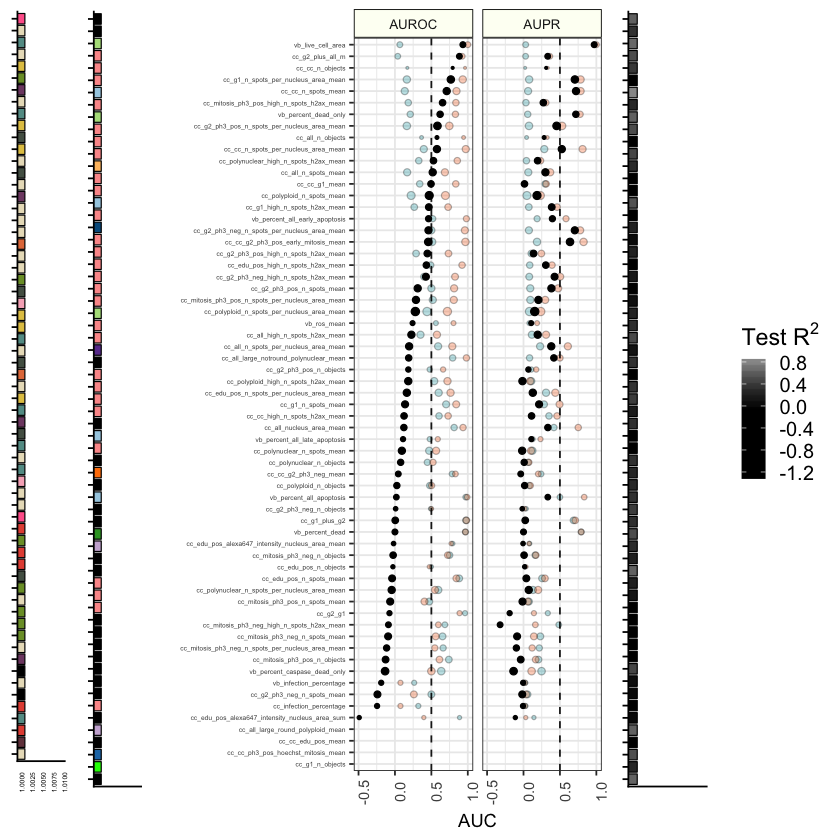

In [17]:
cowplot::plot_grid(
    assay_gg,
    measure_gg,
    classifier_perf_gg,
    regression_performance_comp_gg,
    labels = c("", "", "", ""),
    ncol = 4,
    nrow = 1,
    rel_widths = c(0.1, 0.1, 0.6, 0.3)
    )

In [18]:
# Here is an example of high performing models in classification
# but low performing in regression

metric_diff_df <- auc_test_full_df %>%
    dplyr::filter(shuffle == "real_minus_shuffle",
                  metric == "AUROC") %>%
    dplyr::select(metric, target, auc, shuffle)

high_class_models <- metric_df %>%
    dplyr::left_join(metric_diff_df, by = c("target")) %>%
    dplyr::filter(r_two < 0.4, auc > 0.25) %>%
    dplyr::arrange(desc(AUROC_test))

high_class_models

target,data_fit,shuffle.x,cell_line,mse,r_two,min_class_count,AUROC_train,AUPR_train,AUROC_test,⋯,original_name,feature_type,measurement,maria_thumbs_up,assay,description,r_two_rank,metric,auc,shuffle.y
<fct>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<fct>,<dbl>,<chr>
cc_cc_g2_ph3_pos_early_mitosis_mean,test,shuffle_false,all,0.48677018,0.2244646925,32,0.9049815,0.6322230,0.9673469,⋯,CC - G2+pH3 (Early mitiosis) - Mean per Well,cell_cycle,g2_m_arrest,1,many_cell_cycle,fraction of G2/M cells,29,AUROC,0.4571429,real_minus_shuffle
cc_g2_ph3_neg_n_spots_per_nucleus_area_mean,test,shuffle_false,all,0.59430992,-0.0467678470,28,0.9106494,0.6465206,0.9600000,⋯,G2-pH3 - Number of Spots per Area of Nucleus - Mean per Well,cell_cycle,dna_damage,0,many_cell_cycle,In G2 cells: average number of gH2Ax spots per nucleus area,11,AUROC,0.4600000,real_minus_shuffle
cc_g2_plus_all_m,test,shuffle_false,all,0.20392018,0.3369642561,16,0.9590592,0.5402701,0.9230769,⋯,G2 + All M-phase,cell_cycle,other,0,many_cell_cycle,G2+M,40,AUROC,0.8846154,real_minus_shuffle
cc_edu_pos_high_n_spots_h2ax_mean,test,shuffle_false,all,0.58331756,0.2312739883,22,0.7824329,0.2995514,0.9215686,⋯,edu positive - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,edu_gh2ax,In S phase cells: fraction of >3 gH2Ax spots,30,AUROC,0.4313725,real_minus_shuffle
cc_polynuclear_high_n_spots_h2ax_mean,test,shuffle_false,all,0.34373938,-0.0021041342,22,0.8623423,0.3059101,0.8557692,⋯,large not round (polynuclear) - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,hoechst_gh2ax,In polynuc cells: fraction of >3 gH2Ax spots,14,AUROC,0.5288462,real_minus_shuffle
cc_cc_n_spots_mean,test,shuffle_false,all,0.42143004,0.3830976352,29,0.9234835,0.6974257,0.8448980,⋯,CC - Number of Spots - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within cells selected for cell cycle: average number of gH2AX spots,46,AUROC,0.7102041,real_minus_shuffle
cc_mitosis_ph3_pos_high_n_spots_h2ax_mean,test,shuffle_false,all,0.05709141,-0.1062125964,22,0.6154966,0.1012651,0.8365385,⋯,"pH3 positive, Hoechst condenced (mitosis) - High number of spots gH2AX - Mean per Well",cell_cycle,dna_damage,0,ph3,In M cells: fraction of >3 gH2Ax spots,5,AUROC,0.6538462,real_minus_shuffle
cc_cc_g1_mean,test,shuffle_false,all,0.45148967,0.3008921110,22,0.8356519,0.4143837,0.8350000,⋯,CC - G1 - Mean per Well,cell_cycle,g1_arrest,1,many_cell_cycle,fraction of G1 cells,36,AUROC,0.4950000,real_minus_shuffle
cc_g2_ph3_neg_high_n_spots_h2ax_mean,test,shuffle_false,all,0.51402776,-0.0325729611,26,0.9276590,0.6262533,0.8250000,⋯,G2-pH3 - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,many_cell_cycle,In G2 cells: fraction of >3 gH2Ax spots,12,AUROC,0.4250000,real_minus_shuffle


## Separate Training and Testing Regression Metrics

In [19]:
r_two_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two",
                  shuffle == "shuffle_false",
                  y_transform == "raw") %>%
    tidyr::spread(data_fit, value) %>%
    dplyr::left_join(label_df, by=c("target" = "updated_name"))

r_two_df$measurement <- tidyr::replace_na(r_two_df$measurement, "other")
r_two_df$measurement <- factor(r_two_df$measurement,
                               levels = c("apoptosis",
                                          "death",
                                          "cell_viability",
                                          "toxicity",
                                          "dna_damage",
                                          "cell_cycle_arrest",
                                          "g1_arrest",
                                          "g2_arrest",
                                          "g2_m_arrest",
                                          "mitosis",
                                          "s_arrest",
                                          "other"))

r_two_df$assay <- factor(r_two_df$assay,
                          levels = c("hoechst",
                                     "edu",
                                     "gh2ax",
                                     "ph3",
                                     "hoechst_gh2ax",
                                     "hoechst_edu",
                                     "edu_gh2ax",
                                     "caspase",
                                     "draq",
                                     "draq_caspase",
                                     "many_cell_cycle",
                                     "crispr_efficiency"))
print(dim(r_two_df))
head(r_two_df, 2)

[1] 70 13


metric,target,shuffle,y_transform,cell_line,test,train,original_name,feature_type,measurement,maria_thumbs_up,assay,description
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<fct>,<chr>
r_two,cc_all_high_n_spots_h2ax_mean,shuffle_false,raw,all,0.3252763,0.5436792,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,gh2ax,Within all cells: fraction of cells containing more than 3 gH2AX spots
r_two,cc_all_large_notround_polynuclear_mean,shuffle_false,raw,all,0.1143320,0.6113832,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,hoechst,Fraction of cells with large non-round nuclei


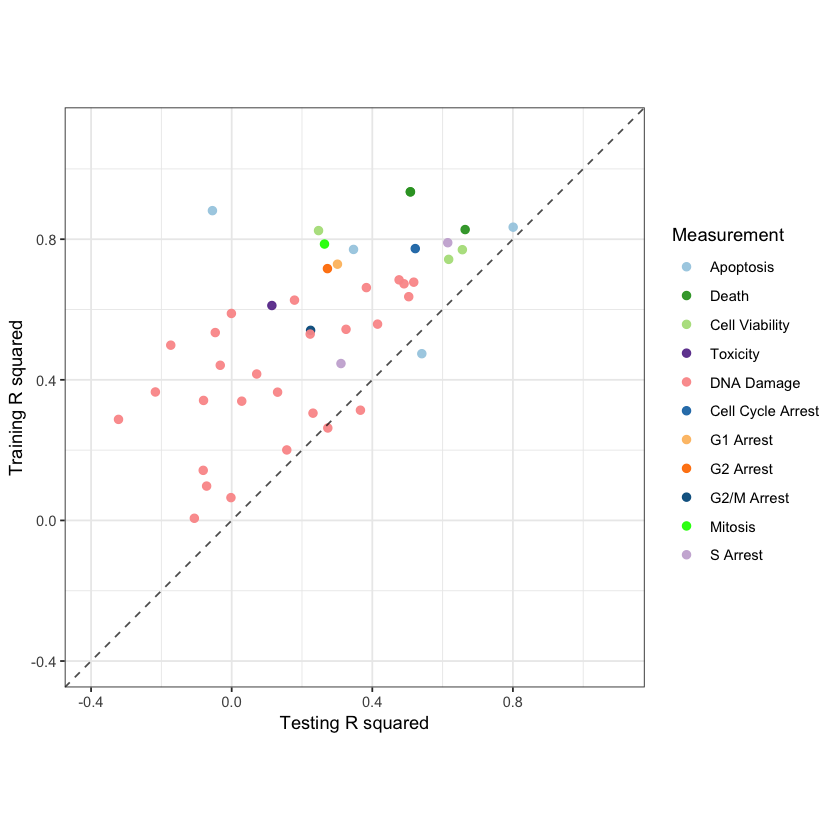

In [20]:
ggplot(r_two_df %>%
       dplyr::filter(measurement != "other"),
       aes(y = train, x = test)) +
    geom_point(alpha = 0.95,
               size = 2,
               aes(color = measurement)) +
    coord_fixed() +
    ylab("Training R squared") +
    xlab("Testing R squared") +
    geom_abline(intercept = 0,
            slope = 1,
            linetype = "dashed",
            color = "black",
            alpha = 0.7) +
    xlim(c(-0.4, 1.1)) +
    ylim(c(-0.4, 1.1)) +
    scale_color_manual(name = "Measurement",
                       values = measurement_colors,
                       labels = measurement_labels) +
    theme_bw()

file <- file.path(figure_dir,
                  paste0("performance_summary_rsquared_", consensus, ".png"))
ggsave(file, dpi = 300, width = 6, height = 4.25)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

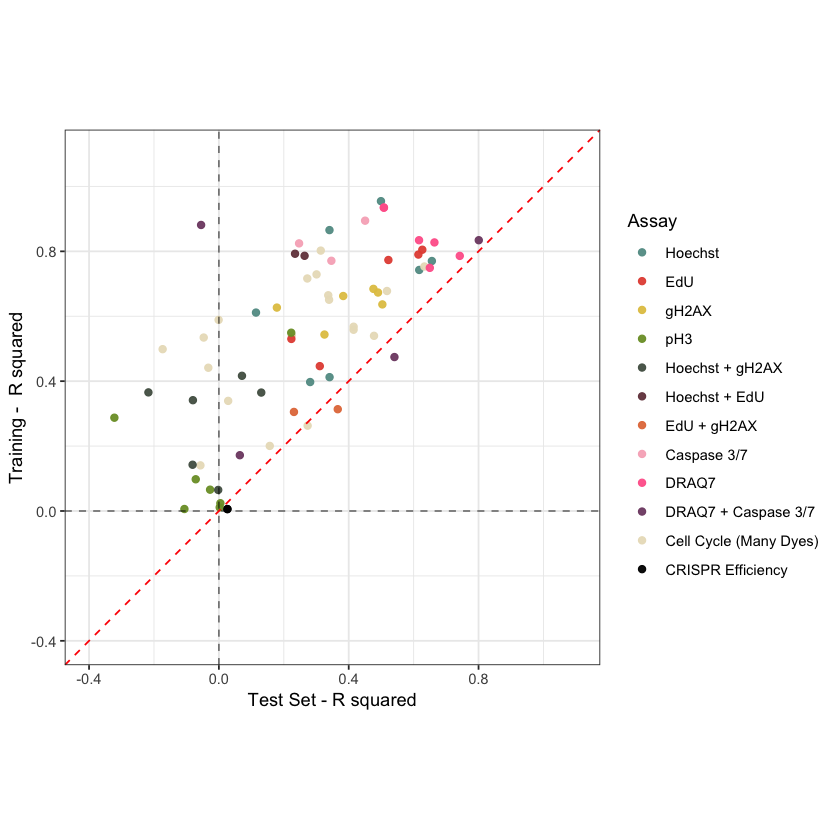

In [21]:
ggplot(r_two_df, aes(y = train, x = test)) +
    geom_point(alpha = 0.95,
               size = 1.7,
               aes(color = assay)) +
    ylab("Training -  R squared") +
    xlab("Test Set - R squared") +
    geom_vline(xintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_hline(yintercept = 0,
               alpha = 0.5, 
               linetype = "dashed") +
    geom_abline(slope = 1,
                intercept = 0, 
                color = "red",
                linetype = "dashed") +
    xlim(c(-0.4, 1.1)) +
    ylim(c(-0.4, 1.1)) +
    coord_fixed() +
    scale_color_manual(name = "Assay",
                       values = dye_colors,
                       labels = dye_labels) +
    theme_bw()

file <- file.path(figure_dir,
                  paste0("performance_summary_rsquared_assay_", consensus, ".png"))
ggsave(file, dpi = 300, width = 6, height = 4.25)

## Compare cytominer with pycytominer

### Regression Results

In [22]:
# Cytominer results are archived on github
hash = "26d1095c209d402102494c0c28e978476643e572"
cyto_file = paste0("https://github.com/broadinstitute/cell-health/raw/",
                   hash, "/3.train/results/full_cell_health_regression_results.tsv.gz")

cyto_regression_df = readr::read_tsv(cyto_file, col_types=readr::cols()) %>%
    dplyr::mutate(package = "cytominer")

head(cyto_regression_df, 2)

mse,metric,target,data_fit,shuffle,y_transform,package
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.6590045,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,cytominer
0.4247787,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,cytominer


In [23]:
regression_metrics_df <- regression_metrics_df %>%
    dplyr::mutate(package = "pycytominer")

head(regression_metrics_df, 2)

value,metric,target,data_fit,shuffle,y_transform,cell_line,package
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.3081967,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,all,pycytominer
0.8929666,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,all,pycytominer


In [24]:
# Note that mse_diff is coded as "value" in pycytominer and "mse" in cytominer
all_regression_df <- regression_metrics_df %>%
    dplyr::inner_join(cyto_regression_df,
                      by = c("metric", "target", "data_fit", "shuffle", "y_transform"),
                      suffix = c("_pycytominer", "_cytominer")) %>%
    dplyr::mutate(mse_diff = value - mse)

head(all_regression_df, 2)

value,metric,target,data_fit,shuffle,y_transform,cell_line,package_pycytominer,mse,package_cytominer,mse_diff
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
0.3081967,mse,cc_all_high_n_spots_h2ax_mean,train,shuffle_true,raw,all,pycytominer,0.6590045,cytominer,-0.3508077
0.8929666,mse,cc_all_high_n_spots_h2ax_mean,test,shuffle_true,raw,all,pycytominer,0.4247787,cytominer,0.4681879


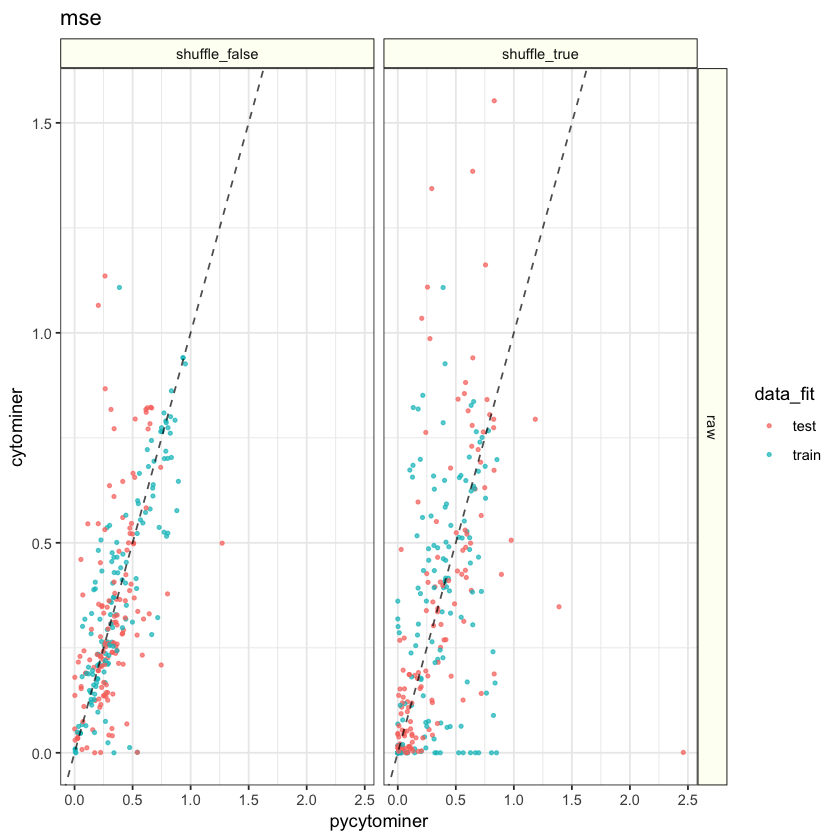

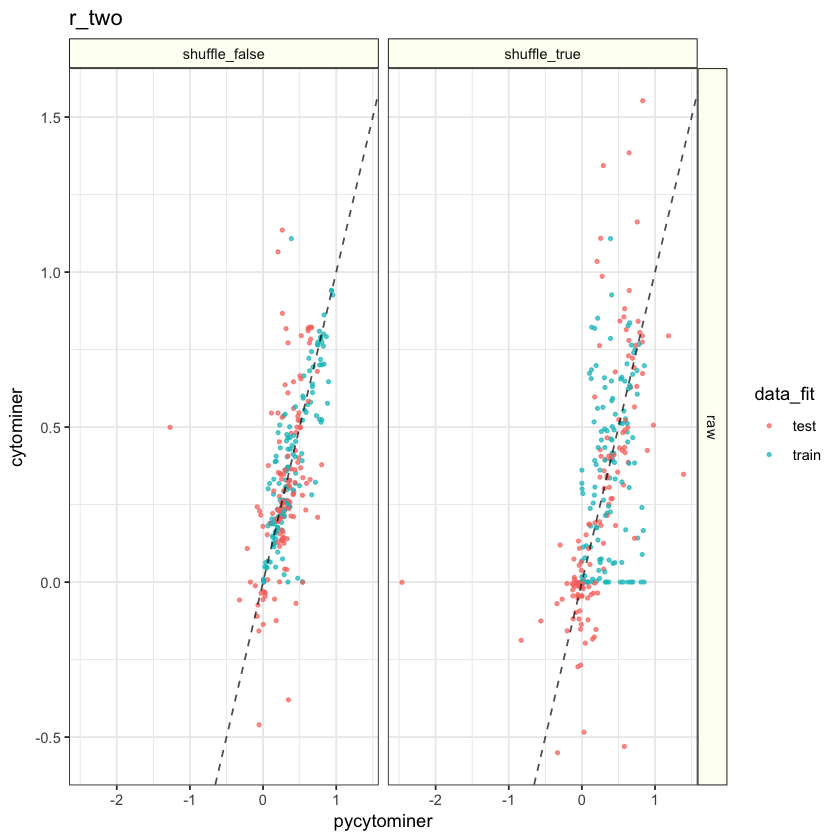

In [25]:
for (metric in unique(all_regression_df$metric)) {
    all_regression_subset_df <- all_regression_df %>%
        dplyr::filter(metric == metric)
    
    if (metric == "mse") {
        all_regression_subset_df$value <- abs(all_regression_subset_df$value)
        all_regression_subset_df$mse <- abs(all_regression_subset_df$mse)
    }
    
    mse_gg <- ggplot(all_regression_subset_df,
       aes(x=value, 
           y=mse)) +
    geom_point(aes(color = data_fit),
               alpha = 0.7,
               size = 0.8) +
    facet_grid(y_transform~shuffle) +
    xlab("pycytominer") +
    ylab("cytominer") +
    ggtitle(metric) +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    theme_bw() +
    theme(strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))
    
    print(mse_gg)
    outfile <- file.path("figures",
                         paste0("compare_pycytominer_cytominer_", metric, "_", consensus, ".png"))
    ggsave(outfile, height = 5, width = 6, dpi = 300)
}



In [26]:
all_regression_df %>%
    dplyr::group_by(metric, data_fit, shuffle, y_transform) %>%
    dplyr::mutate(percent_pycytominer_better = sum(mse_diff > 0) / n()) %>%
    dplyr::distinct(metric, data_fit, shuffle, y_transform, percent_pycytominer_better)

metric,data_fit,shuffle,y_transform,percent_pycytominer_better
<chr>,<chr>,<chr>,<chr>,<dbl>
mse,train,shuffle_true,raw,0.4000000
mse,test,shuffle_true,raw,0.5285714
r_two,train,shuffle_true,raw,0.6571429
r_two,test,shuffle_true,raw,0.4428571
mse,train,shuffle_false,raw,0.4285714
mse,test,shuffle_false,raw,0.7142857
r_two,train,shuffle_false,raw,0.6285714
r_two,test,shuffle_false,raw,0.4428571


### Classification Comparison

In [27]:
# Cytominer results are archived on github
cyto_file = paste0("https://github.com/broadinstitute/cell-health/raw/",
                   hash, "/3.train/results/full_cell_health_roc_results.tsv.gz")

cyto_roc_df = readr::read_tsv(cyto_file, col_types=readr::cols())

head(cyto_roc_df, 2)

fpr,tpr,threshold,metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0,0.000000000,8.538085,roc,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151
0,0.006578947,7.538085,roc,cc_all_high_n_spots_h2ax_mean,0.9018822,train,shuffle_true,binarize,151


In [28]:
cyto_file = paste0("https://github.com/broadinstitute/cell-health/raw/",
                   hash, "/3.train/results/full_cell_health_pr_results.tsv.gz")

cyto_pr_df = readr::read_tsv(cyto_file, col_types=readr::cols())

head(cyto_pr_df, 2)

precision,recall,threshold,metric,target,auc,data_fit,shuffle,y_transform,min_class_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>
0.5779468,1.0000000,-0.8279075,aupr,cc_all_high_n_spots_h2ax_mean,0.9145002,train,shuffle_true,binarize,151
0.5763359,0.9934211,-0.8254211,aupr,cc_all_high_n_spots_h2ax_mean,0.9145002,train,shuffle_true,binarize,151


In [29]:
cyto_auroc_df <- cyto_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

cyto_aupr_df <- cyto_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

cyto_auc_df <- dplyr::bind_rows(cyto_auroc_df, cyto_aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false",
                  data_fit == "test")

cyto_auc_df$metric <- dplyr::recode_factor(
    cyto_auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

cyto_auc_df <- cyto_auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform) %>%
    dplyr::mutate(package = "pycytominer")

print(dim(cyto_auc_df))
head(cyto_auc_df, 2)

[1] 68  7


target,data_fit,shuffle,min_class_count,AUROC,AUPR,package
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,151,0.7750343,0.7919861,pycytominer
cc_all_large_notround_polynuclear_mean,test,shuffle_false,151,0.5226337,0.5404478,pycytominer


In [30]:
auc_df <- auc_df %>%
    dplyr::mutate(package = "cytominer")

In [31]:
all_classification_df <- auc_df %>%
    dplyr::inner_join(cyto_auc_df,
                      by = c("target", "data_fit", "shuffle", "min_class_count"),
                      suffix = c("_pycytominer", "_cytominer")) %>%
    dplyr::mutate(auroc_diff = AUROC - AUROC_test,
                  aupr_diff = AUPR - AUPR_test) %>%
    dplyr::filter(data_fit == "test",
                  shuffle == "shuffle_false") 

head(all_classification_df, 2)

target,shuffle,min_class_count,AUROC_train,AUPR_train,data_fit,AUROC_test,AUPR_test,package_pycytominer,AUROC,AUPR,package_cytominer,auroc_diff,aupr_diff
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>


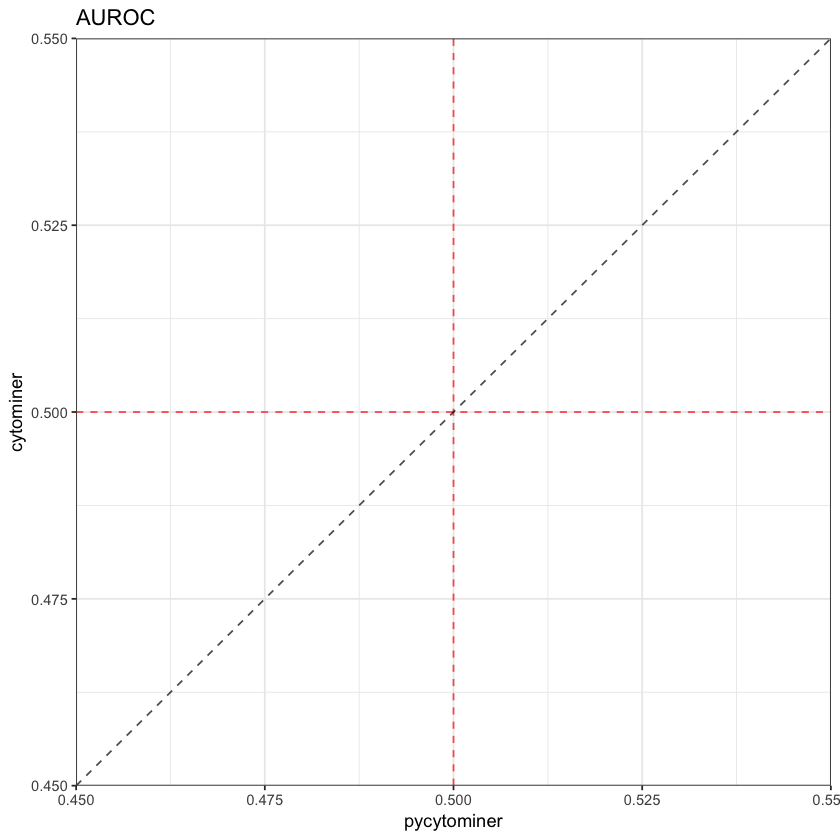

In [32]:
metric <- "AUROC"

label_logic <- abs(all_classification_df$auroc_diff) > 0.08

ggplot(all_classification_df,
       aes(x=AUROC_test, 
           y=AUROC)) +
    geom_point(alpha = 0.7,
               size = 0.8) +
    xlab("pycytominer") +
    ylab("cytominer") +
    geom_hline(yintercept = 0.5,
               linetype = "dashed",
               color = "red",
               alpha = 0.7) +
    geom_vline(xintercept = 0.5,
               linetype = "dashed",
               color = "red",
               alpha = 0.7) +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    ggtitle(metric) +
    geom_text_repel(data = subset(all_classification_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.6,
                    point.padding = 0.3,
                    segment.size = 0.2,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = target,
                        x = AUROC_test,
                        y = AUROC)) +
    theme_bw()

outfile <- file.path("figures",
                     paste0("compare_pycytominer_cytominer_", metric, "_", consensus, ".png"))
ggsave(outfile, height = 3, width = 3, dpi = 300)

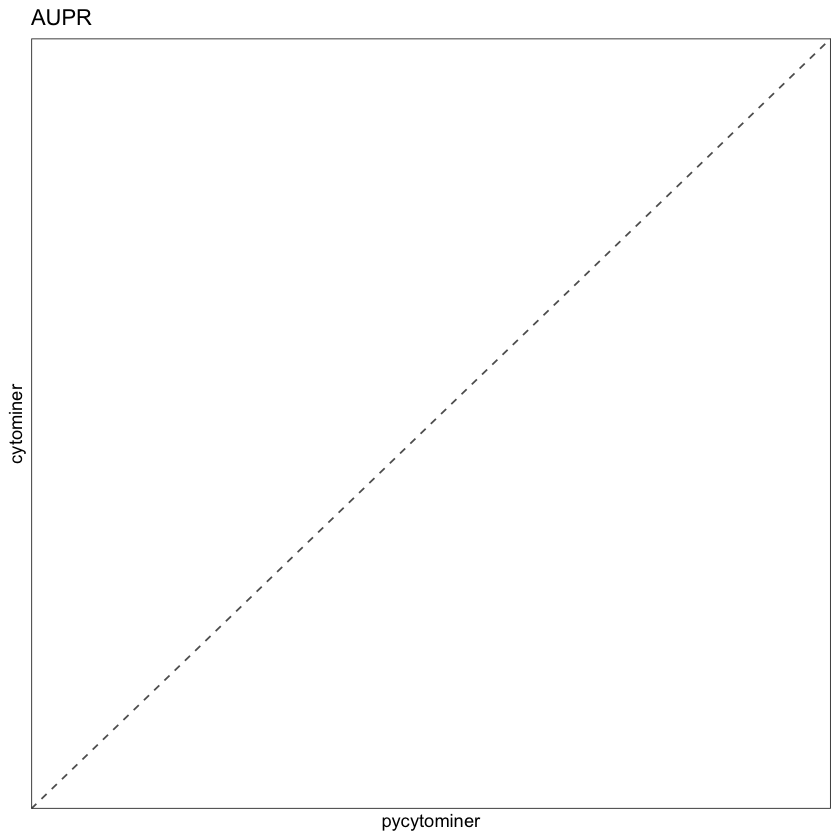

In [33]:
metric <- "AUPR"

label_logic <- abs(all_classification_df$aupr_diff) > 0.08

ggplot(all_classification_df,
       aes(x=AUPR_test, 
           y=AUPR)) +
    geom_point(alpha = 0.7,
               size = 0.8) +
    xlab("pycytominer") +
    ylab("cytominer") +
    geom_abline(intercept = 0,
                slope = 1,
                linetype = "dashed",
                color = "black",
                alpha = 0.7) +
    ggtitle(metric) +
    geom_text_repel(data = subset(all_classification_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.6,
                    point.padding = 0.3,
                    segment.size = 0.2,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = target,
                        x = AUPR_test,
                        y = AUPR)) +
    theme_bw()

outfile <- file.path("figures",
                     paste0("compare_pycytominer_cytominer_", metric, "_", consensus, ".png"))
ggsave(outfile, height = 3, width = 3, dpi = 300)

In [34]:
all_classification_df %>%
    dplyr::mutate(percent_auroc_pycytominer_better = sum(auroc_diff > 0) / n(),
                  percent_aupr_pycytominer_better = sum(aupr_diff > 0) / n()) %>%
    dplyr::distinct(data_fit, shuffle, percent_auroc_pycytominer_better, percent_aupr_pycytominer_better)

data_fit,shuffle,percent_auroc_pycytominer_better,percent_aupr_pycytominer_better
<chr>,<chr>,<dbl>,<dbl>
